In [1]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [4, 2]
from tqdm import tqdm
import numpy as np
from data_processing.neural_networks.RL_Reinforced_Learning.Rl_function_approximation import approach_approx_Q
from IPython.display import clear_output
clear_output()
#from misc_tools.print_latex import print_tex

### How implementation works?
1.  We check if both observation and action spaces are discrete.
    
    If so- its a tabular case. Table has shape with number of dimensions: num_obseration_states + 1 (action dimension)
    
    I consider that we have 1 action dimension and its discrete. Its just what ive encountered.

    Now, in tasks like Frozen Lake (FL) or Cliff Walking (CW) observation states are discrete and have 1 dim:
    
    *   FL: 4x4 = 16 observations, 4 actions
    *   CW: 4*12 = 48 observations, 4 actions
    Table has dimensions of (16,4) or (48,4)

    But environment like:
    *   Taxi has states: 25 taxi positions, 5 possible passenger locations, 4 destinations and actions: 6.

        Ideally table would be of shape (25,5,4,6). But for linear approximation we have to flatten this into 400*6 state-actions.

    __Yeet table, we can request flattened indices by using np.ravel_multi_index().__
    
    _It changes a bit how we calculate weight updates. From one-hot masking to selecting active features. They are the same._

1.  If any of obs of actions are not discrete, we cannot use tabular approach. I approximate state-actions using coarse-coding/ tiling.

1.  $Q(s,a)$ and weight update same as described below.





GOAL: Update rule for $Q(s,a,\vec{w})$:
$$\vec{w} \leftarrow \vec{w} + \alpha[U - \hat q(S_\tau,A_\tau, w)] \nabla \hat q(S_\tau,A_\tau, w)$$
***
Under linear approximation:
$$ \hat q(s,a, \vec{w}) = \vec{w}_q \cdot \vec{x}(s,a) $$
$$\nabla \hat q(S_\tau,A_\tau, w) = \vec{x}(s,a) $$
for __binary__ $\vec{x}(s,a)$ we can store either one-hot encoded features or store indices in a list.

1.  one-hot approach is easily understood from definitions: 
    $$\boxed{\vec{w}_{t+1} = \vec{w}_{t} + \alpha \cdot \bigg[U_t - \vec{w}_q \cdot \vec{x}(s,a)\bigg]\cdot \vec{x}(s,a)}$$
    $\vec{w}$ updates only  features 'masked' by $\vec{x}(s,a)$

2. List approach is simpler but changes definitions- we extract and sum relevant weights. i.e:
    $$\vec{x}(s,a) = [2,46]$$
    $$\hat q(s,a, \vec{w}) = \sum_{i \in x_i(s)} {(w_q)}_i $$ 
    We update only selected weights not by marking but by index-extraction
    $$\boxed{\vec{w}_{t+1}[\vec{x}(s,a)] = \vec{w}_{t}[\vec{x}(s,a)] + \alpha \cdot \bigg[U_t - \sum_{i \in x_i(s)} {(w_q)}_i\bigg]}$$
***

__Previously i could only coarse-code 2D, so i approximated $Q(s,a)$ by splitting it into basis $x(s)$ for $s$ and weights for different actions $a_0,a_1,\dots \rightarrow w_1, w_2,\dots$. Here how it worked.__

In case of simple mountain car env i have state space of velocity and position $S_x, S_v$ and 3 discrete actions no accel, accel left or right.

I can only discretize 2D space $(S_x, S_v)$, but for different actions, tile embedding is the same, so i can reuse them for each approximation.

$$\hat q(s,a, \vec{w}) = \sum_{i = 1}^d w_i(a) x_i(s) = q(s,\vec{w}_a) $$

__Later i was forced to approximate $x(s,a)$, so i remade tiling code and use it here__
***

In [2]:
class n_step_SARSA_APPROX(approach_approx_Q):
    def __init__(self, env_name, eps, tile_params, GAMMA, ALPHA, *args, **kwargs):
        super().__init__(env_name, eps, tile_params, *args, **kwargs)
        self.ALPHA = ALPHA
        self.GAMMA = GAMMA
        
    def update_Wq(self, target, state_action):
        super().update_Wq(step_size = self.ALPHA, target = target, state_action = state_action)
        
tp = (8, 40, 0.1)
env_MC = n_step_SARSA_APPROX('MountainCar-v0', eps = 0.1, tile_params = tp, GAMMA = 1, ALPHA = 1/2/tp[0])

In [3]:
def n_step_SARSA_APPROX_Loop(env: n_step_SARSA_APPROX, n = 5, N = 1):
    times = []
    tq_iter = tqdm(range(N))
    for i in tq_iter:
        env.env_iters   += 1
        t               = 0
        St              = env.reset()    
        At              = env.sample_action(St)
        rewards         = [-1000]
        state_actions   = [St + (At,)]
        T               = float("inf")
        while True:
            if t < T:
                St1, Rt1, St1_terminal   = env.step(At)
                rewards.append(Rt1)
                if St1_terminal:
                    T = t + 1
                else:
                    At1  = env.sample_action(St1)
                    state_actions.append(St1 + (At1,))
                    At = At1
            tau = t - n + 1
            if tau >= 0:
                # add +1 to end range to include it.
                G = sum([env.GAMMA**(i-tau-1)*rewards[i] for i in range(tau+1, min(tau+n,T) + 1)])
                if tau + n < T:
                    G += env.GAMMA**n*env.Qsa(state_actions[tau+n]) 
                env.update_Wq(G, state_actions[tau])
                
            t += 1
            if tau == T - 1:
                times.append(T)
                tq_iter.set_postfix(eps=env.eps, T = T, env_iters = env.env_iters)
                break
        
    return times

In [19]:
perf = n_step_SARSA_APPROX_Loop(env_MC, n = 4, N = 1000)

100%|██████████| 1000/1000 [01:16<00:00, 13.13it/s, T=207, env_iters=3700, eps=0.1]


## State value plot

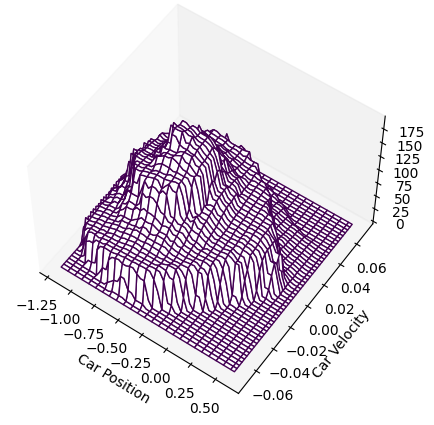

In [20]:
low                 = env_MC.env.observation_space.low
high                = env_MC.env.observation_space.high
minmax_x, minmax_y  = np.vstack((low,high)).T
x = np.linspace(*minmax_x, 50)
y = np.linspace(*minmax_y, 50)

z = np.zeros([len(x), len(y)])
for i in range(len(x)):
  for j in range(len(y)):
    val = np.array([env_MC.Qsa((x[i], y[j],a)) for a in env_MC.actions]).max()
    z[i,j] = val #en.Qsa(2, (x[i], y[j]))
    
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1, 1, 1, projection='3d')
X, Y = np.meshgrid(x, y)
surf = ax.plot_surface(X, Y, -z.T, rstride=1, cstride=2, shade=False, cmap=None, linewidth=1, label='Approximation')
surf.set_edgecolors(surf.to_rgba(surf._A))
surf.set_facecolors("white")
ax.view_init(elev=55., azim=-55)

ax.grid(False)
ax.set_xlabel('Car Position')
ax.set_ylabel('Car Velocity');

## Episode trajectories

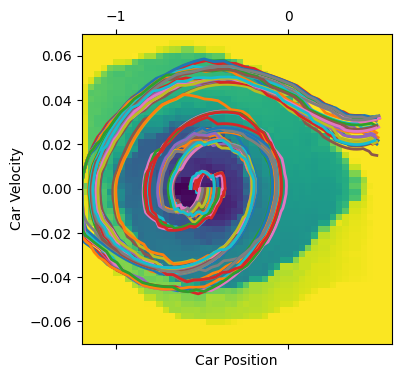

In [21]:
N = 30
plt.matshow(z.T, extent=[*minmax_x,*minmax_y])
for _ in range(N): 
    St                       = env_MC.reset()    
    At                       = env_MC.sample_action(St)
    states = [St]
    T = float("inf")
    while True:
        St1, Rt1, St1_terminal   = env_MC.step(At)
        states.append(St1)
        At1  = env_MC.sample_action(St1)
        At = At1
        if St1_terminal:break
    states = np.array(states)
    plt.plot(*states.T, linewidth = 2)
plt.gca().set_aspect('auto')
plt.gca().set_xlabel('Car Position')
plt.gca().set_ylabel('Car Velocity');

## IDK what i expect of Frozen Lake
I guess just to see if it breaks.

4x4 observations, 4 actions. Everything is discrete

In [52]:
env_FL = n_step_SARSA_APPROX("FrozenLake-v1", eps = 0.1, tile_params = None, GAMMA = 0.99, ALPHA = 1/2, render_mode="rgb_array",map_name = "8x8", is_slippery = False)

In [59]:
perf = n_step_SARSA_APPROX_Loop(env_FL, n = 10, N = 3500)

100%|██████████| 3500/3500 [02:36<00:00, 22.39it/s, T=35, env_iters=6000, eps=0.1]  


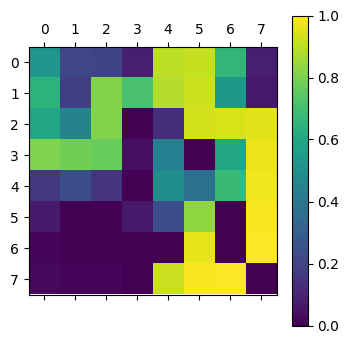

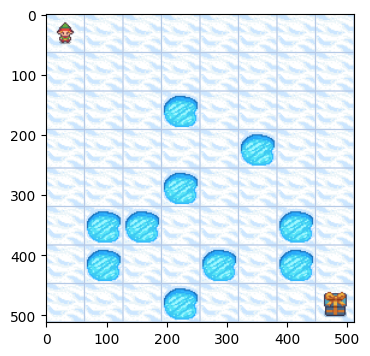

In [60]:
plt.rcParams['figure.figsize'] = [4]*2
FL_num_states_total = env_FL.state_emb.NUM_STATES_TOTAL
gg = []
for i in range(8*8):
    gg.append([env_FL.Qsa((i,a)) for a in env_FL.actions])
gg = np.array(gg).max(-1).reshape(8,8)
c = plt.matshow(gg)
plt.colorbar(c)
plt.show()
env_FL.env.reset()
plt.imshow(env_FL.env.render())
plt.show()